<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/lidar_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

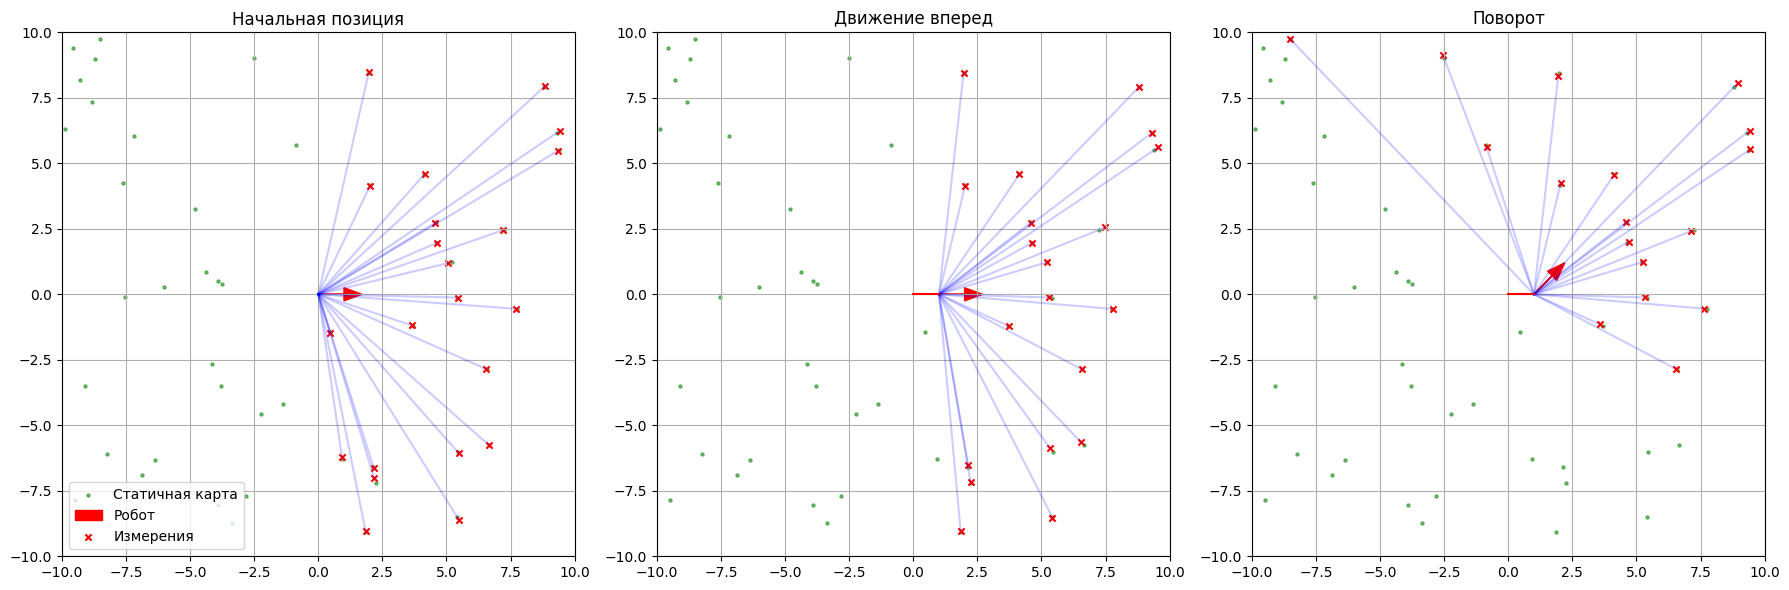

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
MAP_SIZE = 20
NUM_POINTS = 50
NOISE_STD = 0.1
ROBOT_SPEED = 1.0
TURN_ANGLE = np.pi/4  # 45 градусов

# Создаем статичную карту (не изменяется)
np.random.seed(42)
static_map = np.random.uniform(-MAP_SIZE/2, MAP_SIZE/2, (NUM_POINTS, 2))

# Матричные операции для преобразований
def rotation_matrix(angle):
    """Матрица поворота 2x2"""
    return np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

def get_visible_points(points, pos, angle, fov=np.pi, max_range=MAP_SIZE):
    """Получает видимые точки в поле зрения робота"""
    # Переносим точки в систему координат робота
    translated = points - pos

    # Поворачиваем точки (чтобы ось робота смотрела вперед)
    R = rotation_matrix(-angle)  # обратный поворот
    local_points = translated @ R.T

    # Фильтруем точки в поле зрения
    angles = np.arctan2(local_points[:,1], local_points[:,0])
    distances = np.linalg.norm(local_points, axis=1)

    in_fov = np.abs(angles) <= fov/2
    in_range = distances <= max_range
    visible = in_fov & in_range

    # Добавляем шум только к расстояниям
    noisy_distances = distances[visible] + np.random.normal(0, NOISE_STD, np.sum(visible))
    noisy_local = np.column_stack([
        noisy_distances * np.cos(angles[visible]),
        noisy_distances * np.sin(angles[visible])
    ])

    # Возвращаем точки в глобальные координаты
    return noisy_local @ R + pos

# Траектория робота: [начало, движение вперед, поворот]
robot_positions = np.array([
    [0.0, 0.0],                     # 1. Начальная позиция
    [ROBOT_SPEED, 0.0],              # 2. Движение вперед
    [ROBOT_SPEED, 0.0]               # 3. Остаемся на месте (только поворот)
])

robot_angles = np.array([0.0, 0.0, TURN_ANGLE])

# Получаем измерения для каждой позиции
measurements = [get_visible_points(static_map, p, a) for p, a in zip(robot_positions, robot_angles)]

# Визуализация
plt.figure(figsize=(18, 6))

for i in range(3):
    plt.subplot(1, 3, i+1)

    # Статичная карта (всегда одинаковая)
    plt.scatter(static_map[:,0], static_map[:,1], c='green', s=5, alpha=0.5, label='Статичная карта' if i==0 else "")

    # Робот (красная стрелка)
    pos = robot_positions[i]
    angle = robot_angles[i]
    dx, dy = np.cos(angle), np.sin(angle)
    plt.arrow(pos[0], pos[1], dx, dy, head_width=0.5, head_length=0.7, fc='red', ec='red', label='Робот' if i==0 else "")

    # Измерения лидара
    if len(measurements[i]) > 0:
        plt.scatter(measurements[i][:,0], measurements[i][:,1], c='red', s=20, marker='x', label='Измерения' if i==0 else "")
        # Линии от робота к точкам
        for point in measurements[i]:
            plt.plot([pos[0], point[0]], [pos[1], point[1]], 'b-', alpha=0.2)

    # Траектория
    if i > 0:
        plt.plot(robot_positions[:i+1,0], robot_positions[:i+1,1], 'r-', label='Траектория' if i==1 else "")

    plt.title(['Начальная позиция', 'Движение вперед', 'Поворот'][i])
    plt.xlim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.ylim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

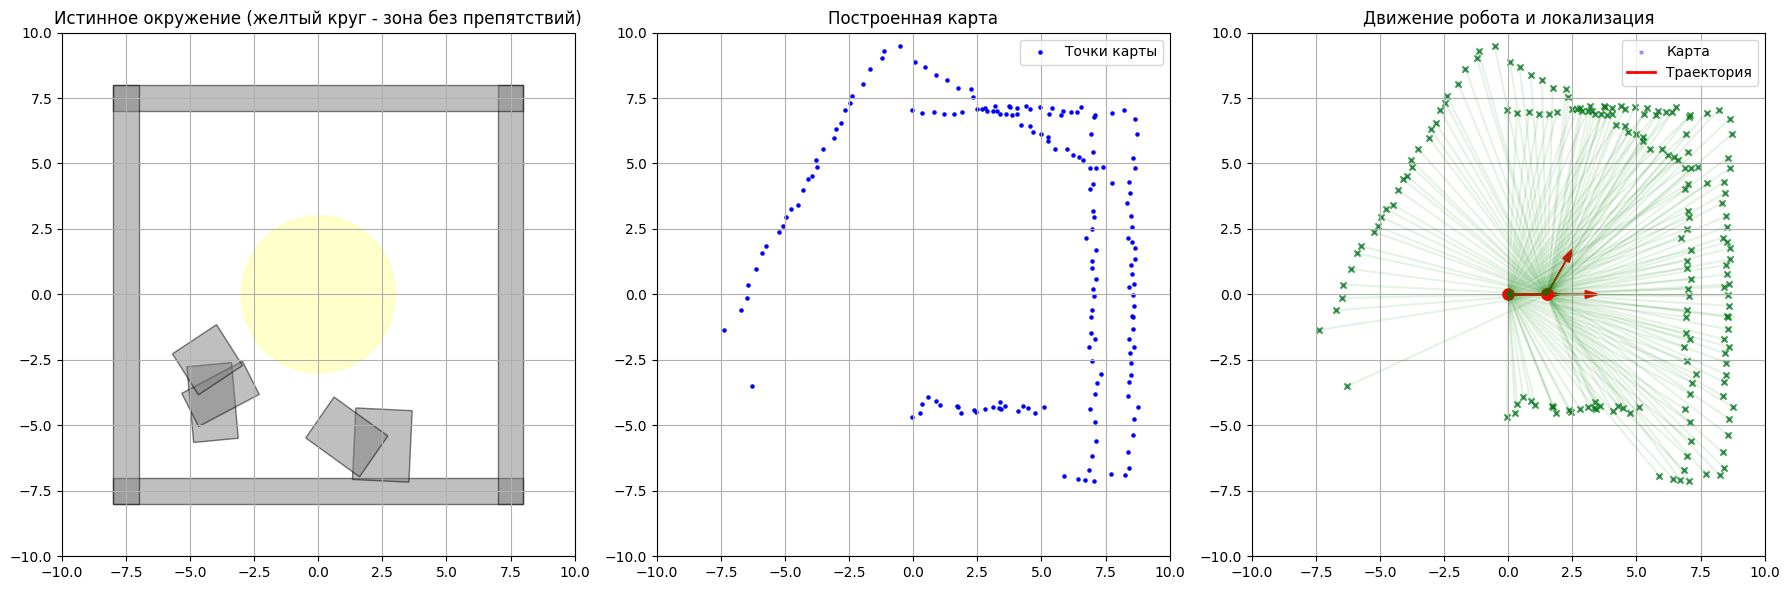

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from matplotlib.patches import Polygon

# Параметры
MAP_SIZE = 20
NUM_LANDMARKS = 30
NOISE_STD = 0.1
ROBOT_SPEED = 1.5
TURN_ANGLE = np.pi/3  # 60 градусов
LIDAR_RANGE = 10
LIDAR_FOV = np.pi  # 180 градусов
CENTER_ZONE_RADIUS = 3.0  # Зона вокруг центра без препятствий

## 1. Генерация статичной карты (окружение с препятствиями)
def generate_environment():
    # Стены по периметру
    walls = [
        np.array([[-8, -8], [8, -8], [8, -7], [-8, -7]]),  # нижняя
        np.array([[8, -8], [8, 8], [7, 8], [7, -8]]),      # правая
        np.array([[8, 8], [-8, 8], [-8, 7], [8, 7]]),      # верхняя
        np.array([[-8, 8], [-8, -8], [-7, -8], [-7, 8]]),  # левая
    ]

    # Случайные прямоугольные препятствия (не ближе CENTER_ZONE_RADIUS от центра)
    obstacles = []
    np.random.seed(42)
    attempts = 0
    max_attempts = 20

    while len(obstacles) < 5 and attempts < max_attempts:
        w, h = np.random.uniform(1, 3, 2)

        # Генерируем позицию, пока не найдем подходящую (вне центральной зоны)
        while True:
            x, y = np.random.uniform(-6, 6, 2)
            if np.sqrt(x**2 + y**2) > CENTER_ZONE_RADIUS + max(w, h)/2:
                break

        angle = np.random.uniform(0, np.pi/2)
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        points = np.array([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
        rotated = points @ R.T + np.array([x, y])

        # Проверяем, что препятствие не пересекает центральную зону
        min_dist = min(np.linalg.norm(point) for point in rotated)
        if min_dist > CENTER_ZONE_RADIUS:
            obstacles.append(rotated)

        attempts += 1

    return walls + obstacles

## 2. Модель лидара
def simulate_lidar(robot_pos, robot_angle, environment):
    angles = np.linspace(robot_angle - LIDAR_FOV/2,
                         robot_angle + LIDAR_FOV/2, 60)
    measurements = []

    for angle in angles:
        ray_end = robot_pos + LIDAR_RANGE * np.array([np.cos(angle), np.sin(angle)])
        closest_intersection = None
        min_dist = LIDAR_RANGE

        for poly in environment:
            for i in range(len(poly)):
                p1 = poly[i]
                p2 = poly[(i + 1) % len(poly)]

                # Проверка пересечения луча с отрезком
                den = (p2[0] - p1[0]) * (robot_pos[1] - ray_end[1]) - \
                      (p2[1] - p1[1]) * (robot_pos[0] - ray_end[0])
                if abs(den) < 1e-6:
                    continue

                t = ((p1[1] - ray_end[1]) * (robot_pos[0] - ray_end[0]) - \
                    (p1[0] - ray_end[0]) * (robot_pos[1] - ray_end[1]))
                t /= den

                u = ((p1[1] - p2[1]) * (robot_pos[0] - p1[0]) - \
                     (p1[0] - p2[0]) * (robot_pos[1] - p1[1])) / den

                if 0 <= t <= 1 and 0 <= u <= 1:
                    intersection = p1 + t * (p2 - p1)
                    dist = np.linalg.norm(intersection - robot_pos)
                    if dist < min_dist:
                        min_dist = dist
                        closest_intersection = intersection

        if closest_intersection is not None:
            # Добавляем шум
            noise = np.random.normal(0, NOISE_STD, 2)
            measurements.append(closest_intersection + noise)

    return np.array(measurements) if measurements else np.zeros((0, 2))

## 3. Построение карты
def build_map(robot_trajectory, all_measurements):
    map_points = []
    for i, (pos, angle) in enumerate(robot_trajectory):
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        # Преобразуем измерения в глобальные координаты
        global_points = pos + all_measurements[i] @ R.T
        map_points.extend(global_points)

    return np.unique(np.array(map_points), axis=0)

## 4. Локализация робота на карте
def localize_robot(lidar_scan, map_points, initial_guess, max_iter=20):
    kdtree = KDTree(map_points)
    pos = np.array(initial_guess[:2])
    angle = initial_guess[2]

    for _ in range(max_iter):
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        global_points = pos + lidar_scan @ R.T

        _, match_indices = kdtree.query(global_points, k=1)
        matched_map_points = map_points[match_indices]

        error = matched_map_points - global_points
        mean_error = np.mean(error, axis=0)

        pos += 0.3 * mean_error  # Коэффициент сглаживания

        if np.linalg.norm(mean_error) < 0.05:
            break

    return (*pos, angle)

## 5. Основная симуляция
def main_simulation():
    # Генерируем окружение
    environment = generate_environment()

    # Траектория робота: [начало, движение вперед, поворот]
    robot_trajectory = [
        (np.array([0.0, 0.0]), 0.0),       # Начальная позиция
        (np.array([ROBOT_SPEED, 0.0]), 0.0),  # Движение вперед
        (np.array([ROBOT_SPEED, 0.0]), TURN_ANGLE)  # Поворот на месте
    ]

    # Симулируем данные лидара для каждой позиции
    all_measurements = []
    for pos, angle in robot_trajectory:
        scan = simulate_lidar(pos, angle, environment)
        all_measurements.append(scan)

    # Строим карту по всем измерениям
    static_map = build_map(robot_trajectory, all_measurements)

    # Визуализация
    plt.figure(figsize=(18, 6))

    # 1. Отображаем истинное окружение
    plt.subplot(1, 3, 1)
    for poly in environment:
        plt.gca().add_patch(Polygon(poly, alpha=0.5, edgecolor='k', facecolor='gray'))

    # Отмечаем центральную зону
    center_circle = plt.Circle((0, 0), CENTER_ZONE_RADIUS, color='yellow', alpha=0.2)
    plt.gca().add_patch(center_circle)

    plt.title("Истинное окружение (желтый круг - зона без препятствий)")
    plt.xlim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.ylim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.grid(True)

    # 2. Отображаем построенную карту
    plt.subplot(1, 3, 2)
    plt.scatter(static_map[:, 0], static_map[:, 1], s=5, c='blue', label='Точки карты')
    plt.title("Построенная карта")
    plt.xlim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.ylim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.grid(True)
    plt.legend()

    # 3. Отображаем траекторию и локализацию
    plt.subplot(1, 3, 3)

    # Отображаем карту
    plt.scatter(static_map[:, 0], static_map[:, 1], s=5, c='blue', alpha=0.3, label='Карта')

    # Отображаем траекторию
    traj = np.array([pos for pos, _ in robot_trajectory])
    plt.plot(traj[:, 0], traj[:, 1], 'r-', linewidth=2, label='Траектория')

    # Отображаем робота и его измерения
    for i, ((pos, angle), measurements) in enumerate(zip(robot_trajectory, all_measurements)):
        # Преобразуем измерения в глобальные координаты
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        global_meas = pos + measurements @ R.T

        # Робот
        plt.plot(pos[0], pos[1], 'ro', markersize=8)
        dx, dy = 1.5 * np.cos(angle), 1.5 * np.sin(angle)
        plt.arrow(pos[0], pos[1], dx, dy, head_width=0.3, head_length=0.5, fc='red', ec='red')

        # Измерения
        if len(global_meas) > 0:
            plt.scatter(global_meas[:, 0], global_meas[:, 1], s=20, c='green', marker='x', alpha=0.7)
            for point in global_meas:
                plt.plot([pos[0], point[0]], [pos[1], point[1]], 'g-', alpha=0.1)

    plt.title("Движение робота и локализация")
    plt.xlim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.ylim(-MAP_SIZE/2, MAP_SIZE/2)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Запуск симуляции
main_simulation()

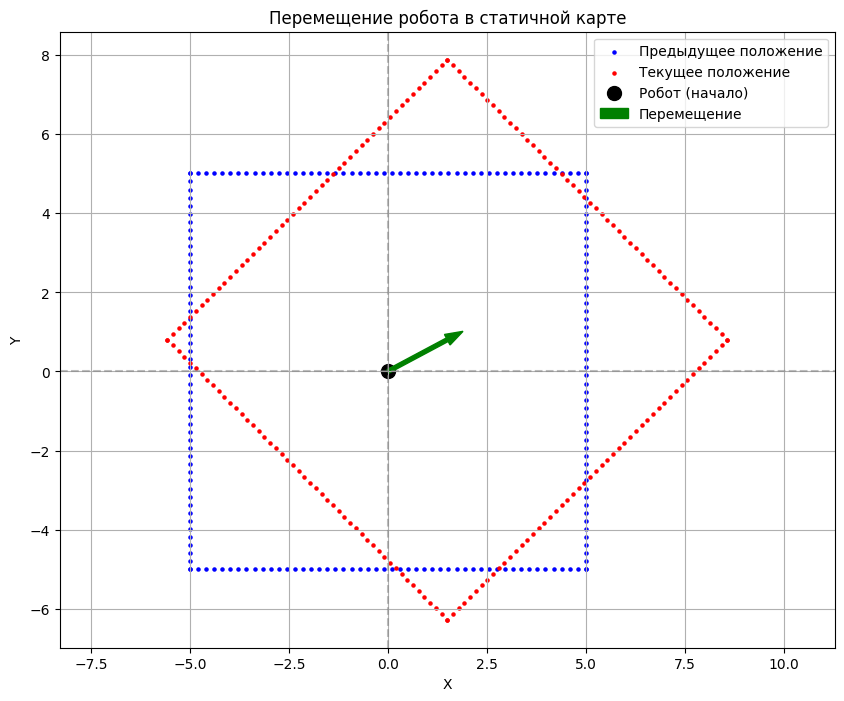

Истинное смещение: dx=1.50, dy=0.80, θ=45.00°
Найденное смещение: dx=1.50, dy=0.80, θ=45.00°


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для нахождения смещения и поворота между двумя облаками точек
def find_transform(prev_points, curr_points):
    # Находим центры масс
    prev_center = np.mean(prev_points, axis=0)
    curr_center = np.mean(curr_points, axis=0)

    # Центрируем точки
    prev_centered = prev_points - prev_center
    curr_centered = curr_points - curr_center

    # Вычисляем матрицу ковариации
    H = prev_centered.T @ curr_centered

    # Находим поворот через SVD
    U, _, Vt = np.linalg.svd(H)
    rotation = Vt.T @ U.T
    dtheta = np.arctan2(rotation[1, 0], rotation[0, 0])

    # Вычисляем смещение
    dx = curr_center[0] - (prev_center[0] * np.cos(dtheta) - prev_center[1] * np.sin(dtheta))
    dy = curr_center[1] - (prev_center[0] * np.sin(dtheta) + prev_center[1] * np.cos(dtheta))

    return dx, dy, dtheta

# Создаем пример данных
def generate_points():
    # Генерируем "комнату" (4 стены)
    walls = [
        np.column_stack([np.linspace(-5, 5, 50), np.full(50, -5)]),  # нижняя стена
        np.column_stack([np.linspace(-5, 5, 50), np.full(50, 5)]),    # верхняя стена
        np.column_stack([np.full(50, -5), np.linspace(-5, 5, 50)]),    # левая стена
        np.column_stack([np.full(50, 5), np.linspace(-5, 5, 50)]),     # правая стена
    ]
    return np.vstack(walls)

# Генерация данных
prev_points = generate_points()  # Предыдущее положение (робот в центре)
dx, dy, dtheta = 1.5, 0.8, np.pi/4  # Смещение и поворот робота
rotation_matrix = np.array([
    [np.cos(dtheta), -np.sin(dtheta)],
    [np.sin(dtheta), np.cos(dtheta)]
])
curr_points = (prev_points @ rotation_matrix.T) + np.array([dx, dy])  # Текущее положение

# Находим преобразование
found_dx, found_dy, found_dtheta = find_transform(prev_points, curr_points)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(prev_points[:, 0], prev_points[:, 1], c='blue', s=5, label='Предыдущее положение')
plt.scatter(curr_points[:, 0], curr_points[:, 1], c='red', s=5, label='Текущее положение')

# Робот (начинает в центре)
plt.scatter(0, 0, c='black', s=100, marker='o', label='Робот (начало)')
plt.arrow(0, 0, found_dx, found_dy, width=0.1, head_width=0.3,
          color='green', label='Перемещение')

plt.axhline(0, c='gray', ls='--', alpha=0.5)
plt.axvline(0, c='gray', ls='--', alpha=0.5)
plt.legend()
plt.grid(True)
plt.title("Перемещение робота в статичной карте")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

# Вывод результатов
print(f"Истинное смещение: dx={dx:.2f}, dy={dy:.2f}, θ={np.degrees(dtheta):.2f}°")
print(f"Найденное смещение: dx={found_dx:.2f}, dy={found_dy:.2f}, θ={np.degrees(found_dtheta):.2f}°")

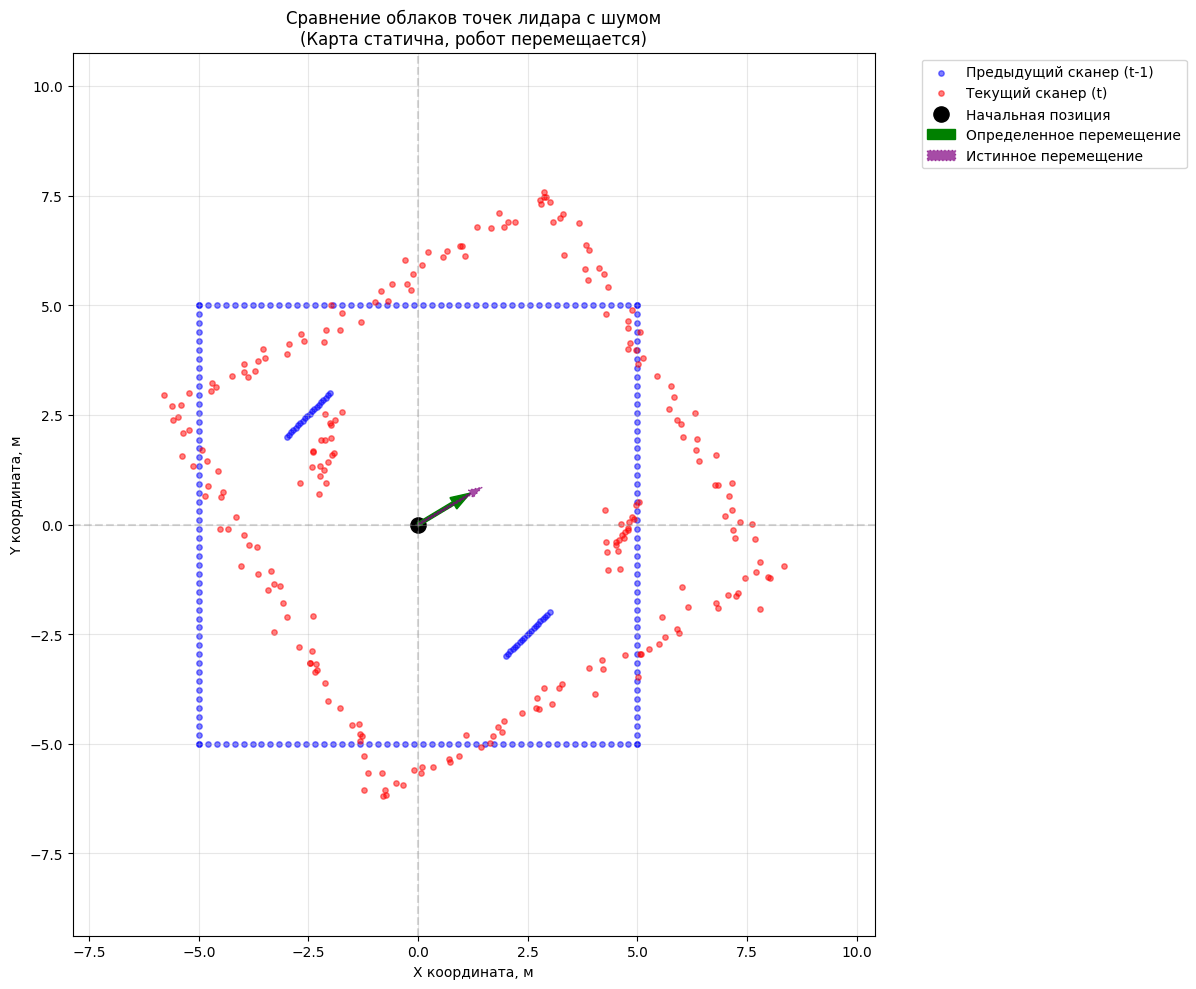

Результаты обработки данных лидара:
Истинное смещение: dx=1.20 м, dy=0.70 м, θ=30.0°
Определенное смещение: dx=1.19 м, dy=0.72 м, θ=30.0°
Ошибка: 0.020 м, 0.0°


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def add_noise(points, noise_level=0.2):
    """Добавляет шум к точкам"""
    noise = np.random.normal(scale=noise_level, size=points.shape)
    return points + noise

def find_transform(prev_points, curr_points):
    """Находит смещение между двумя облаками точек"""
    prev_center = np.mean(prev_points, axis=0)
    curr_center = np.mean(curr_points, axis=0)

    prev_centered = prev_points - prev_center
    curr_centered = curr_points - curr_center

    H = prev_centered.T @ curr_centered
    U, _, Vt = np.linalg.svd(H)
    rotation = Vt.T @ U.T
    dtheta = np.arctan2(rotation[1, 0], rotation[0, 0])

    dx = curr_center[0] - (prev_center[0]*np.cos(dtheta) - prev_center[1]*np.sin(dtheta))
    dy = curr_center[1] - (prev_center[0]*np.sin(dtheta) + prev_center[1]*np.cos(dtheta))

    return dx, dy, dtheta

# Генерация "комнаты" с препятствиями
def generate_room():
    walls = [
        np.column_stack([np.linspace(-5, 5, 50), np.full(50, -5)]),  # нижняя стена
        np.column_stack([np.linspace(-5, 5, 50), np.full(50, 5)]),    # верхняя стена
        np.column_stack([np.full(50, -5), np.linspace(-5, 5, 50)]),    # левая стена
        np.column_stack([np.full(50, 5), np.linspace(-5, 5, 50)]),     # правая стена
    ]
    obstacles = [
        np.column_stack([np.linspace(-3, -2, 20), np.linspace(2, 3, 20)]),
        np.column_stack([np.linspace(2, 3, 20), np.linspace(-3, -2, 20)])
    ]
    return np.vstack(walls + obstacles)

# Создаем данные
prev_points = generate_room()
dx, dy, dtheta = 1.2, 0.7, np.pi/6  # Смещение робота

# Применяем преобразование и добавляем шум
rotation_matrix = np.array([
    [np.cos(dtheta), -np.sin(dtheta)],
    [np.sin(dtheta), np.cos(dtheta)]
])
curr_points = add_noise((prev_points @ rotation_matrix.T) + np.array([dx, dy]))

# Находим преобразование
found_dx, found_dy, found_dtheta = find_transform(prev_points, curr_points)

# Визуализация
plt.figure(figsize=(12, 10))
plt.scatter(prev_points[:, 0], prev_points[:, 1], c='blue', s=15, alpha=0.5,
           label='Предыдущий сканер (t-1)')
plt.scatter(curr_points[:, 0], curr_points[:, 1], c='red', s=15, alpha=0.5,
           label='Текущий сканер (t)')

# Отображение робота и его движения
plt.scatter(0, 0, c='black', s=120, marker='o', label='Начальная позиция')
plt.arrow(0, 0, found_dx, found_dy, width=0.08, head_width=0.3,
         color='green', length_includes_head=True, label='Определенное перемещение')

# Истинное перемещение (для сравнения)
plt.arrow(0, 0, dx, dy, width=0.05, head_width=0.2,
         color='purple', linestyle=':', alpha=0.7, label='Истинное перемещение')

plt.axhline(0, c='gray', ls='--', alpha=0.3)
plt.axvline(0, c='gray', ls='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.title("Сравнение облаков точек лидара с шумом\n(Карта статична, робот перемещается)")
plt.xlabel("X координата, м")
plt.ylabel("Y координата, м")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Вывод результатов
print("Результаты обработки данных лидара:")
print(f"Истинное смещение: dx={dx:.2f} м, dy={dy:.2f} м, θ={np.degrees(dtheta):.1f}°")
print(f"Определенное смещение: dx={found_dx:.2f} м, dy={found_dy:.2f} м, θ={np.degrees(found_dtheta):.1f}°")
print(f"Ошибка: {np.sqrt((dx-found_dx)**2 + (dy-found_dy)**2):.3f} м, {np.degrees(abs(dtheta-found_dtheta)):.1f}°")

Анализ перемещения робота:
Истинные параметры: Δx=1.30 м, Δy=0.80 м, θ=36.0°
Вычисленные параметры: Δx=1.29 м, Δy=0.80 м, θ=36.1°
Ошибка: 0.007 м, 0.1°


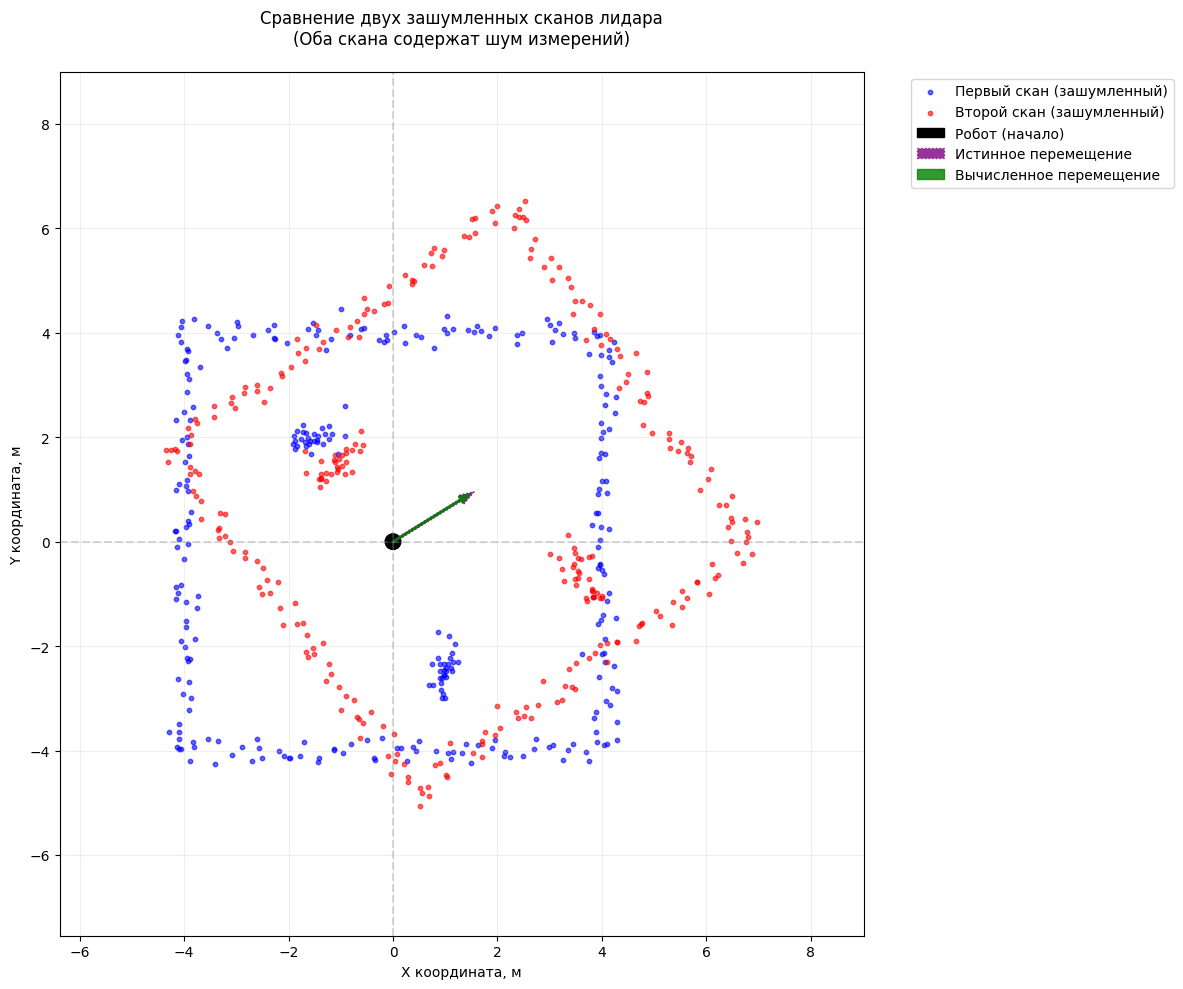

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def add_noise(points, noise_level=0.15):
    """Добавляет гауссовский шум к точкам"""
    return points + np.random.normal(scale=noise_level, size=points.shape)

def find_transform(source, target):
    """Вычисляет смещение между двумя зашумленными облаками точек"""
    # Центры масс
    src_center = np.mean(source, axis=0)
    tgt_center = np.mean(target, axis=0)

    # Центрированные точки
    src_centered = source - src_center
    tgt_centered = target - tgt_center

    # Матрица ковариации
    H = src_centered.T @ tgt_centered

    # SVD-разложение
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Угол поворота
    theta = np.arctan2(R[1, 0], R[0, 0])

    # Смещение с учетом поворота
    dx = tgt_center[0] - (src_center[0]*np.cos(theta) - src_center[1]*np.sin(theta))
    dy = tgt_center[1] - (src_center[0]*np.sin(theta) + src_center[1]*np.cos(theta))

    return dx, dy, theta

# Генерация реалистичной карты помещения
def generate_environment():
    # Стены комнаты
    walls = [
        np.column_stack([np.linspace(-4, 4, 60), np.full(60, -4)]),  # нижняя
        np.column_stack([np.linspace(-4, 4, 60), np.full(60, 4)]),   # верхняя
        np.column_stack([np.full(60, -4), np.linspace(-4, 4, 60)]),  # левая
        np.column_stack([np.full(60, 4), np.linspace(-4, 4, 60)]),  # правая
    ]

    # Препятствия
    obstacles = [
        np.column_stack([np.linspace(-2, -1, 30), np.full(30, 2)]),  # горизонтальный
        np.column_stack([np.full(30, 1), np.linspace(-3, -2, 30)]),   # вертикальный
    ]

    return np.vstack(walls + obstacles)

# Параметры движения робота
true_dx, true_dy, true_theta = 1.3, 0.8, np.pi/5  # ~36°

# Генерация и зашумление данных
env_points = generate_environment()
rotation = np.array([
    [np.cos(true_theta), -np.sin(true_theta)],
    [np.sin(true_theta), np.cos(true_theta)]
])

# Первый скан (с шумом)
scan1 = add_noise(env_points)

# Второй скан (смещенный + шум)
scan2 = add_noise(env_points @ rotation.T + np.array([true_dx, true_dy]))

# Вычисление преобразования
est_dx, est_dy, est_theta = find_transform(scan1, scan2)

# Визуализация
plt.figure(figsize=(12, 10))
plt.scatter(scan1[:, 0], scan1[:, 1], c='blue', s=10, alpha=0.6,
           label='Первый скан (зашумленный)')
plt.scatter(scan2[:, 0], scan2[:, 1], c='red', s=10, alpha=0.6,
           label='Второй скан (зашумленный)')

# Отображение робота и перемещения
robot = plt.Circle((0, 0), 0.15, color='black', label='Робот (начало)')
plt.gca().add_patch(robot)

# Истинное и вычисленное перемещение
plt.arrow(0, 0, true_dx, true_dy, width=0.05, head_width=0.2,
          color='purple', linestyle=':', alpha=0.8, label='Истинное перемещение')
plt.arrow(0, 0, est_dx, est_dy, width=0.03, head_width=0.15,
          color='green', alpha=0.8, label='Вычисленное перемещение')

# Настройки графика
plt.axhline(0, c='gray', ls='--', alpha=0.3)
plt.axvline(0, c='gray', ls='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.title("Сравнение двух зашумленных сканов лидара\n(Оба скана содержат шум измерений)", pad=20)
plt.xlabel("X координата, м")
plt.ylabel("Y координата, м")
plt.axis('equal')
plt.tight_layout()

# Вывод результатов
print("Анализ перемещения робота:")
print(f"Истинные параметры: Δx={true_dx:.2f} м, Δy={true_dy:.2f} м, θ={np.degrees(true_theta):.1f}°")
print(f"Вычисленные параметры: Δx={est_dx:.2f} м, Δy={est_dy:.2f} м, θ={np.degrees(est_theta):.1f}°")
print(f"Ошибка: {np.sqrt((true_dx-est_dx)**2 + (true_dy-est_dy)**2):.3f} м, {np.degrees(abs(true_theta-est_theta)):.1f}°")

plt.show()